# Decision trees


## 1. Decision Tree Implementation

### 1.1. Learning algorithm
We want to learn the decision tree from data.

To implement the ID3 algorithm - we need a tree data structure.
The first thing to do is to define a `Node` class.

In [1]:
class DecisionNode:
    def __init__(self, col=-1, value=None, results=None, tb=None, fb=None):
        self.col = col # attribute on which to split
        self.value = value # value on which to split
        self.results = results #If the node has no children - we store here class labels with their counts
        self.tb = tb  # True branch
        self.fb = fb  # False branch

Dividing set of observations `rows` based on the value `value` in column `column`.
It can split on numeric value (greater than or equal) or on categorical value (equal/not equal).

In [2]:
def split(rows, column, value):
    # define split function according to the value type
    split_function = None
    if isinstance(value, int) or isinstance(value, float):
        split_function = lambda row: row[column] >= value
    else:
        split_function = lambda row: row[column] == value

    # Divide the rows into two sets and return them
    set1 = [row for row in rows if split_function(row)]
    set2 = [row for row in rows if not split_function(row)]
    return (set1, set2)

To evaluate the quality of the split, we need to count the occurrence of each class label in the current subset (potential tree node).

In [3]:
def count_labels(rows):
    label_count = {}
    for row in rows:
        # The class label is in the last column
        label = row[- 1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    return label_count

Different methods to evaluate the homogeneity of the target variable within a given subset generated by split.

* GINI:  probability that two items randomly selected fall into the same class. We use here GINI impurity, because we want to use the same code which chooses the best split based on the **minimum** of the score. GINI impurity = 1.0 - GINI.
* Entropy: the sum of $-p(x)\log(p(x))$ across all the different possible classes $x$.
* Variance: variance is used if the target variable can be considered a number. In this case we build a special type of decision tree - a **Regression Tree**.

In [4]:
from math import log

def gini_impurity(rows):
    total = len(rows)
    counts = count_labels(rows)
    gini = 0
    for key, val in counts.items():
        p = val / total
        gini += p*p
        
    return (1 - gini)

def entropy(rows):
    total = len(rows)
    counts = count_labels(rows)
    ent = 0.0
    for key,val in counts.items():
        p = val / total
        ent = ent - p * log(p, 2)
    return ent


def variance(rows):
    if len(rows) == 0: return 0
    num_label = [float(row[- 1]) for row in rows]
    mean = sum(num_label) / len(num_label)
    variance = sum([(d - mean) ** 2 for d in num_label]) / len(num_label)
    return variance


Now we have everything to build the decision tree from data.

The `buildtree` function below takes as an input all the rows of the dataset and returns a decision tree with the root  implemented as `DecisionNode` class.

The default `score_func` to test the quality of the split is entropy, but any other score can be applied by passing any of the scoring functions above. Remember that `variance` can only be applied if the target variable is numeric (Regression Tree).

To avoid overfitting, the algorithm uses additional stop criteria: if the improvement of the score is less than `min_improvement` or if the number of samples in every node is less than `min_samples`, then the splitting of samples stops. For the sake of the visual demo, there is also a parameter called `max_depth`, which controls the maximum depth of the tree. 

With the default values the algorithm will continue until the score of the node stops improving.

In [5]:
def buildtree(rows, score_func=entropy, min_improvement=0, min_samples=0, max_depth=None, depth=0):
    if len(rows) == 0:
        return DecisionNode()
    # Compute overall score for the entire rows dataset
    current_score = score_func(rows)

    # Set up accumulator variables to track the best split criteria
    best_score = current_score
    best_criteria = None
    best_sets = None

    column_count = len(rows[0]) - 1
    for col in range(0, column_count):
        # Generate the list of unique values in
        # this column to split on them
        column_values = set()
        for row in rows:
            column_values.add(row[col])
            
        # Now try splitting the rows 
        # on each unique value in this column
        for value in column_values:
            (set1, set2) = split(rows, col, value)

            # Evaluate the quality of the split
            # p is the proportion of subset set1 
            p = float(len(set1)) / len(rows)
            split_score = p * score_func(set1) + (1-p) * score_func(set2)
            
            if split_score < best_score and \
                (len(set1) > min_samples or len(set2) > min_samples) and \
                (current_score - split_score) > min_improvement:
                best_score = split_score
                best_criteria = (col, value)
                best_sets = (set1, set2)

    # Create the sub branches
    if (current_score - best_score) > min_improvement and \
        (max_depth is None or (max_depth is not None and depth < max_depth)) :
        # print("Splitting on",best_criteria, " 2 sets:", len(best_sets[0]),len(best_sets[1]))
        true_branch = buildtree(best_sets[0], score_func, min_improvement, min_samples, max_depth, depth+1)
        false_branch = buildtree(best_sets[1], score_func, min_improvement, min_samples, max_depth, depth+1)
        return DecisionNode(col=best_criteria[0], value=best_criteria[1],
                            tb=true_branch, fb=false_branch)
    else: # Done splitting - summarize class labels in leaf nodes
        return DecisionNode(results=count_labels(rows))

## 2. Using learned tree for classification

### 2.1. Classifying fruits

First, build the tree from data.

In [6]:
# fruits with their size and color
fruits = [
    [4, 'red', 'apple'],
    [4, 'green', 'apple'],
    [1.5, 'red', 'cherry'],
    [1, 'green', 'grape'],
    [5, 'red', 'apple'],
     [1.2, 'red', 'grape']
]

tree = buildtree(fruits)

The `prediction` function below outputs the label of the leaf node according to a prevalent class.
It cannot be used for regression trees - you need to implement your own function if you want to use this code for predicting a numeric target.

In [7]:
def prediction(leaf_labels):
    total = 0
    result = {}
    for label, count in leaf_labels.items():
        total += count
        result[label] = count

    for label, val in result.items():
        result[label] = str(int(result[label]/total * 100))+"%"

    return result

Two ways to display the tree: **print with indent** and **tree drawing**.

In [8]:
def print_tree(tree, current_branch, attributes=None,  indent='', leaf_funct=prediction):
    # Is this a leaf node?
    if tree.results != None:
        print(indent + current_branch + str(leaf_funct(tree.results)))
    else:
        # Print the split question
        split_col = str(tree.col)
        if attributes is not None:
            split_col = attributes[tree.col]
        split_val = str(tree.value)
        if type(tree.value) == int or type(tree.value) == float:
            split_val = ">=" + str(tree.value)
        print(indent + current_branch + split_col + ': ' + split_val + '? ')

        # Print the branches
        indent = indent + '  '
        print_tree(tree.tb, 'T->', attributes, indent)
        print_tree(tree.fb, 'F->', attributes, indent)

In [9]:
print_tree(tree, '', ["size", "color"])

size: >=4? 
  T->{'apple': '100%'}
  F->size: >=1.5? 
    T->{'cherry': '100%'}
    F->{'grape': '100%'}


In [10]:
from PIL import Image, ImageDraw


def getwidth(tree):
    if tree.tb == None and tree.fb == None: return 1
    return getwidth(tree.tb) + getwidth(tree.fb)


def getdepth(tree):
    if tree.tb == None and tree.fb == None: return 0
    return max(getdepth(tree.tb), getdepth(tree.fb)) + 1


def drawtree(tree, jpeg='tree.jpg', attributes=None):
    w = getwidth(tree) * 100
    h = getdepth(tree) * 100 + 120

    img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    drawnode(draw, tree, w / 2, 20, attributes)
    img.save(jpeg, 'JPEG')


def drawnode(draw, tree, x, y, attributes=None):
    if tree.results == None:
        # Get the width of each branch
        w1 = getwidth(tree.fb) * 100
        w2 = getwidth(tree.tb) * 100

        # Determine the total space required by this node
        left = x - (w1 + w2) / 2
        right = x + (w1 + w2) / 2

        # Draw the condition string
        if attributes is not None:
            draw.text((x - 20, y - 10), str(attributes[tree.col])[0:5] + ':' + str(tree.value), (0, 0, 0))
        else:
            draw.text((x - 20, y - 10), str(tree.col)[0:5] + ':' + str(tree.value), (0, 0, 0))        

        # Draw links to the branches
        draw.line((x, y, left + w1 / 2, y + 100), fill=(255, 0, 0))
        draw.line((x, y, right - w2 / 2, y + 100), fill=(255, 0, 0))

        # Draw the branch nodes
        drawnode(draw, tree.fb, left + w1 / 2, y + 100, attributes)
        drawnode(draw, tree.tb, right - w2 / 2, y + 100, attributes)
    else:
        txt = ' \n'.join(['%s:%d' % v for v in tree.results.items()])
        draw.text((x - 20, y), txt, (0, 0, 0))

In [11]:
drawtree(tree, jpeg='fruits_dt.jpg', attributes=["size", "color"] )

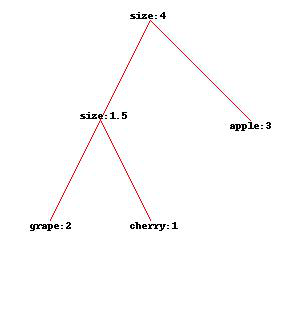

In [12]:
from PIL import Image               # to load images
from IPython.display import display # to display images

pil_im = Image.open('fruits_dt.jpg')
display(pil_im)

The classification is done by traversing the tree starting at the root and selecting the subtree according to the values of the attributes in a sample that we are trying to classify.

In [13]:
def classify(observation, tree):
    if tree.results != None:
        return prediction(tree.results)
    else:
        v = observation[tree.col]
        branch = None
        if isinstance(v, int) or isinstance(v, float):
            if v >= tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        else:
            if v == tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        return classify(observation, branch)


# Classify an observation with missing data
def mdclassify(observation, tree):
    if tree.results != None:
        return prediction(tree.results)
    else:
        v = observation[tree.col]
        if v == None:
            tr, fr = mdclassify(observation, tree.tb), mdclassify(observation, tree.fb)
            tcount = sum(tr.values())
            fcount = sum(fr.values())
            tw = float(tcount) / (tcount + fcount)
            fw = float(fcount) / (tcount + fcount)
            result = {}
            for k, v in tr.items(): result[k] = v * tw
            for k, v in fr.items(): result[k] = v * fw
            return result
        else:
            if isinstance(v, int) or isinstance(v, float):
                if v >= tree.value:
                    branch = tree.tb
                else:
                    branch = tree.fb
            else:
                if v == tree.value:
                    branch = tree.tb
                else:
                    branch = tree.fb
            return mdclassify(observation, branch)

def max_depth(tree):
    if tree.results != None:
        return 0
    else:
        # Compute the depth of each subtree
        tDepth = max_depth(tree.tb)
        fDepth = max_depth(tree.fb)

        # Use the larger one
        if (tDepth > fDepth):
            return tDepth + 1
        else:
            return fDepth + 1

### 2.2. Titanic: predicting survival

Let's try to learn which attributes were important for survival of Titanic passengers. We use the same [titanic](https://docs.google.com/spreadsheets/d/1W0TCr30twkLtCuBl_ryCqBtkfiCP98tAOVi5AebMh34/edit?usp=sharing) dataset.

In [14]:
data_file = "../../data_ml_2020/titanic.csv"

In [15]:
import pandas as pd
data = pd.read_csv(data_file)

In [16]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Let's take only a subset of categorical attributes:

In [17]:
data = data[['Pclass', 'Sex', 'Age', 'Survived'] ]
print(data.columns)
len(data)

Index(['Pclass', 'Sex', 'Age', 'Survived'], dtype='object')


891

For the sake of the demo, remove all the records with missing values.

In [18]:
data = data.dropna(how="any")
len(data)

714

Our custom algorithm takes as an input a regular Python list.

In [19]:
data_rows = data.to_numpy().tolist()
print(data_rows[:10])

[[3, 'male', 22.0, 0], [1, 'female', 38.0, 1], [3, 'female', 26.0, 1], [1, 'female', 35.0, 1], [3, 'male', 35.0, 0], [1, 'male', 54.0, 0], [3, 'male', 2.0, 0], [3, 'female', 27.0, 1], [2, 'female', 14.0, 1], [3, 'female', 4.0, 1]]


The last column is treated as a class label by our algorithm.

In [20]:
columns_list = data.columns.to_numpy().tolist()
print(columns_list)

['Pclass', 'Sex', 'Age', 'Survived']


In [21]:
tree = buildtree(data_rows, score_func=entropy, min_improvement=0, min_samples=0, max_depth=4)

In [22]:
print_tree(tree, '', columns_list)

Sex: female? 
  T->Pclass: >=3? 
    T->Age: >=39.0? 
      T->Age: >=63.0? 
        T->{1: '100%'}
        F->{0: '100%'}
      F->Age: >=2.0? 
        T->{1: '48%', 0: '51%'}
        F->{1: '100%'}
    F->Age: >=3.0? 
      T->Age: >=24.0? 
        T->{1: '93%', 0: '6%'}
        F->{1: '100%'}
      F->Pclass: >=2? 
        T->{1: '100%'}
        F->{0: '100%'}
  F->Pclass: >=2? 
    T->Age: >=10.0? 
      T->Age: >=32.5? 
        T->{0: '94%', 1: '5%'}
        F->{0: '86%', 1: '13%'}
      F->Pclass: >=3? 
        T->{0: '61%', 1: '38%'}
        F->{1: '100%'}
    F->Age: >=54.0? 
      T->Age: >=80.0? 
        T->{1: '100%'}
        F->{0: '90%', 1: '9%'}
      F->Age: >=18.0? 
        T->{1: '44%', 0: '56%'}
        F->{1: '100%'}


## 3. Coronavirus risk factors

As discussed in the lecture, decision trees can be used not only for classification, but also to find out which atttributes are most important in classifying the record into a specific class. In this part we want to find out which symptoms/chronic conditions contribute most to the deadly outcome from catching COVID-19.

Tis Mexican dataset which contains the information from the Statistical Yearbooks of Morbidity 2015-2017 (as well as the information regarding cases associated with COVID-19) was found on [kaggle](https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset).

Download the preprocessed dataset which contains only patients that tested positive for COVID-19 and with all categorical attributes: [link](https://docs.google.com/spreadsheets/d/1EPewR1KdT8mszXJMuqELRTHAVIFHEJw9VwLsb9whKPI/edit?usp=sharing).

In this dataset we have the following attributes:
1. sex: 1 -woman, 2-man
2. age: numeric
3. diabetes: yes/no
4. copd (chronic obstructive pulmonary disease): yes/no
5. asthma: yes/no
6. imm_supr (suppressed immune system): yes/no
7. hypertension: yes/no
8. cardiovascular: yes/no
9. renal_chronic: yes/no
10. tobacco: yes/no	
11. outcome: alive/dead

In [23]:
data_file = "../../data_ml_2020/covid_categorical_good.csv"

In [24]:
import pandas as pd
data = pd.read_csv(data_file)
data = data.dropna(how="any")
data.columns

Index(['sex', 'age', 'diabetes', 'copd', 'asthma', 'imm_supr', 'hypertension',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'outcome'],
      dtype='object')

In [25]:
data_rows = data.to_numpy().tolist()
len(data_rows)

219179

In [26]:
columns_list = data.columns.to_numpy().tolist()
print(columns_list)

['sex', 'age', 'diabetes', 'copd', 'asthma', 'imm_supr', 'hypertension', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'outcome']


### 3.1. Using custom decision tree algorithm

In [27]:
tree = buildtree(data_rows, score_func=entropy, min_improvement=0, min_samples=0, max_depth=7)

In [28]:
print_tree(tree, '', columns_list)

age: >=52? 
  T->age: >=65? 
    T->age: >=71? 
      T->sex: female? 
        T->diabetes: no? 
          T->age: >=76? 
            T->age: >=94? 
              T->{'alive': '74%', 'dead': '25%'}
              F->{'alive': '62%', 'dead': '37%'}
            F->obesity: no? 
              T->{'dead': '28%', 'alive': '71%'}
              F->{'dead': '39%', 'alive': '60%'}
          F->renal_chronic: no? 
            T->age: >=78? 
              T->{'alive': '55%', 'dead': '44%'}
              F->{'alive': '61%', 'dead': '38%'}
            F->age: >=93? 
              T->{'alive': '100%'}
              F->{'dead': '53%', 'alive': '46%'}
        F->age: >=80? 
          T->age: >=106? 
            T->{'alive': '100%'}
            F->hypertension: no? 
              T->{'dead': '45%', 'alive': '54%'}
              F->{'alive': '50%', 'dead': '49%'}
          F->diabetes: yes? 
            T->renal_chronic: no? 
              T->{'dead': '45%', 'alive': '54%'}
              F->{'alive': '45

### 3.2. Using sklearn

The decision tree algorithm in sklearn library is not implemented very well. It requires all the attributes to be numeric - while decision trees work best with the categorical attributes. The dataset for this part contains numeric attributes and can be found [here](https://docs.google.com/spreadsheets/d/1FHTP2RtclUg05GztDW-diMbajMAynPnECW8hyjNLUys/edit?usp=sharing).

In this dataset the binary yes/no attributes are presented as:
* YES: 1
* NO: 2 

In [29]:
data_file =  "../../data_ml_2020/covid_numeric.csv"

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import tree

In [31]:
data = pd.read_csv(data_file)

Remove rows with missing values

In [32]:
for k in ['sex', 'diabetes', 'copd', 'asthma', 'imm_supr', 'hypertension',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco']:
    data[k].replace({97: np.nan, 98: np.nan, 99: np.nan}, inplace=True)


data = data.dropna()
len(data)

219179

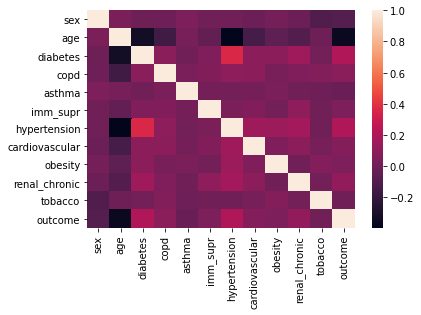

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data_num = data.copy()
conditions = [ data_num['outcome'].eq("alive"), data_num['outcome'].eq('dead')]
choices = [2,1]

data_num['outcome'] = np.select(conditions, choices, default=np.nan)

corr = data_num.corr()
sns.heatmap(corr)

Divide dataset into features and class label.

In [34]:
X = data.loc[:, data.columns != 'outcome']
print(X.columns)

Y = data.loc[:, data.columns == 'outcome']
print(Y.columns)

Index(['sex', 'age', 'diabetes', 'copd', 'asthma', 'imm_supr', 'hypertension',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco'],
      dtype='object')
Index(['outcome'], dtype='object')


Split dataset intro training and testing.

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

Different parameters can be specified to build the model:

`model = tree.DecisionTreeClassifier(
        criterion='entropy', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features=None, 
        random_state=None, 
        min_density=None, 
        compute_importances=None, 
        max_leaf_nodes=None)`

In [36]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 7)
model.fit(X_train,Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [37]:
columns_list = data.columns.to_numpy().tolist()
from sklearn.tree import export_text
r = export_text(model, feature_names=columns_list[:-1])
print(r)

|--- age <= 51.50
|   |--- age <= 39.50
|   |   |--- diabetes <= 1.50
|   |   |   |--- renal_chronic <= 1.50
|   |   |   |   |--- asthma <= 1.50
|   |   |   |   |   |--- class: alive
|   |   |   |   |--- asthma >  1.50
|   |   |   |   |   |--- imm_supr <= 1.50
|   |   |   |   |   |   |--- age <= 38.50
|   |   |   |   |   |   |   |--- class: dead
|   |   |   |   |   |   |--- age >  38.50
|   |   |   |   |   |   |   |--- class: alive
|   |   |   |   |   |--- imm_supr >  1.50
|   |   |   |   |   |   |--- age <= 35.50
|   |   |   |   |   |   |   |--- class: alive
|   |   |   |   |   |   |--- age >  35.50
|   |   |   |   |   |   |   |--- class: alive
|   |   |   |--- renal_chronic >  1.50
|   |   |   |   |--- age <= 33.50
|   |   |   |   |   |--- obesity <= 1.50
|   |   |   |   |   |   |--- age <= 23.50
|   |   |   |   |   |   |   |--- class: alive
|   |   |   |   |   |   |--- age >  23.50
|   |   |   |   |   |   |   |--- class: alive
|   |   |   |   |   |--- obesity >  1.50
|   |   |   |  

What are the most important comorbidity factors? Hard to tell. 
We will try to discover them more efficiently in the next lab using classification rules.

Copyright &copy; 2020 Marina Barsky. All rights reserved.